In [14]:
import os
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score, make_scorer, log_loss, brier_score_loss
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# import xgboost as xgb
from xgboost import XGBClassifier

from skopt import BayesSearchCV

from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns

from skopt.space import Real, Integer

from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setup metrics (see: http://business-analytic.co.uk/blog/evaluating-expected-goals-models/)
# define Mcfadden's pseduo r-squared
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)

In [3]:
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [4]:
# Load the data
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','competition_gender','match_week'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name','smart_pass','carry_length','pass_end_x','pass_end_y',
                 'goalkeeper_x', 'goalkeeper_y','n_angle','area_goal','area_shot','shot_one_on_one','shot_open_goal',
                'under_pressure'], axis=1, inplace=True)
df_non_penalty = df[~mask_penalty].copy()
X_penalty = df_penalty.drop('goal', axis=1)
y_penalty = df_penalty.goal
X = df_non_penalty.drop('goal', axis=1)
y = df_non_penalty.goal

In [5]:
# Split into train, calibration and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_penalty_train, X_penalty_test, y_penalty_train, y_penalty_test = train_test_split(X_penalty, y_penalty,
                                                                        train_size=0.8, random_state=42, stratify=y_penalty)

In [6]:
# Load and split fake data
df_fake = pd.read_parquet(os.path.join(cwd, 'data', 'fake_shots.parquet'))
df_fake.drop(['competition_gender','competition_gender','match_week'], axis=1, inplace=True)
df_fake.index = ['a'+str(idx) for idx in df_fake.index]

y_fake = df_fake.goal
X_fake = df_fake.drop('goal', axis=1)

In [7]:
# Add fake training data. I am not adding this to the test data as want this to be realistic of real data.
X_train = pd.concat([X_train, X_fake])
y_train = pd.concat([y_train, y_fake])

In [8]:
# Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    
    # replace boolean type columns (not really as have nans)
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one',
                'shot_open_goal', 'under_pressure', 'smart_pass']:
        df[col] = df[col].astype(np.float32)
    return df
    
X_train = clean_lightgbm(X_train)
X_test = clean_lightgbm(X_test)

In [9]:
# Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.
def clean_lightgbm_p(df):
    df = df.copy()
    # replace categorical columns
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    return df
    
X_penalty_train = clean_lightgbm_p(X_penalty_train)
X_penalty_test = clean_lightgbm_p(X_penalty_test)

In [12]:
xgb = CalibratedClassifierCV(XGBClassifier(random_state=42), method='isotonic', cv=3)
xgb_param_grid = {'base_estimator__min_child_weight': Integer(0, 10),
                   'base_estimator__reg_lambda': Real(0, 1),
                   'base_estimator__reg_alpha': Real(0, 1),
                   'base_estimator__max_depth': Integer(0, 500)}

In [ ]:
searchcv_xgb = BayesSearchCV(estimator=xgb,
                             n_iter=100,
                             search_spaces=xgb_param_grid,
                             cv=5,
                             n_jobs=-1)
searchcv_xgb.fit(X_train, y_train)
y_pred_xgb = searchcv_xgb.best_estimator_.predict_proba(X_test)

In [11]:
# Permutation importance
# note not using fake data for permutation importance
perm_result = permutation_importance(xgb_np, X_train, y_train, n_repeats=10, random_state=42)
y_pred_xgb_calibrated = xgb_np.predict_proba(X_test)
df_perm_importance = pd.DataFrame({'Feature':X_train.columns,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)
df_perm_importance

,Feature,importance,std_dev
0,visible_angle,0.009229,0.000277
1,distance_to_goal,0.007009,0.000158
2,body_part_name,0.001764,0.000241
3,goalkeeper_x,0.001306,0.000097
4,shot_type_name,0.001239,0.000205
5,n_angle,0.001179,0.000083
6,pass_height_name,0.000720,0.000165
7,distance_visible_angle,0.000620,0.000130
8,area_shot,0.000599,0.000106
9,shot_player_number,0.000597,0.000074


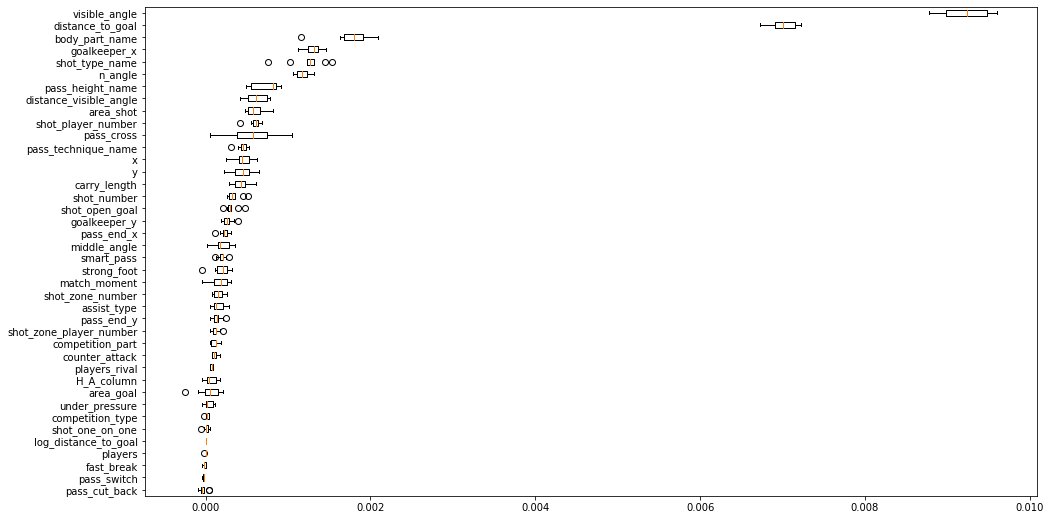

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])

In [13]:
xgb_p = XGBClassifier(objective='binary:logistic', eval_metric='logloss', max_depth=8, learning_rate=0.05, alpha=10,
                       n_estimators=100, n_jobs=-1, random_state=42)
xgb_p.fit(X_penalty_train, y_penalty_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=10, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [14]:
# Permutation importance
# note not using fake data for permutation importance
perm_result_p = permutation_importance(xgb_p, X_penalty_train, y_penalty_train, n_repeats=10, random_state=42)
y_pred_xgb_calibrated_p = xgb_p.predict_proba(X_penalty_test)
df_perm_importance_p = pd.DataFrame({'Feature':X_penalty_train.columns,
                                   'importance': perm_result_p.importances.mean(axis=1),
                                   'std_dev': perm_result_p.importances.std(axis=1)})
df_perm_importance_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_p.reset_index(drop=True, inplace=True)
df_perm_importance_p

,Feature,importance,std_dev
0,shot_player_number,0.008537,0.003284
1,competition_type,0.000000,0.000000
2,competition_part,0.000000,0.000000
3,H_A_column,0.000000,0.000000
4,match_moment,0.000000,0.000000
5,shot_number,0.000000,0.000000
6,players,0.000000,0.000000
7,players_rival,0.000000,0.000000


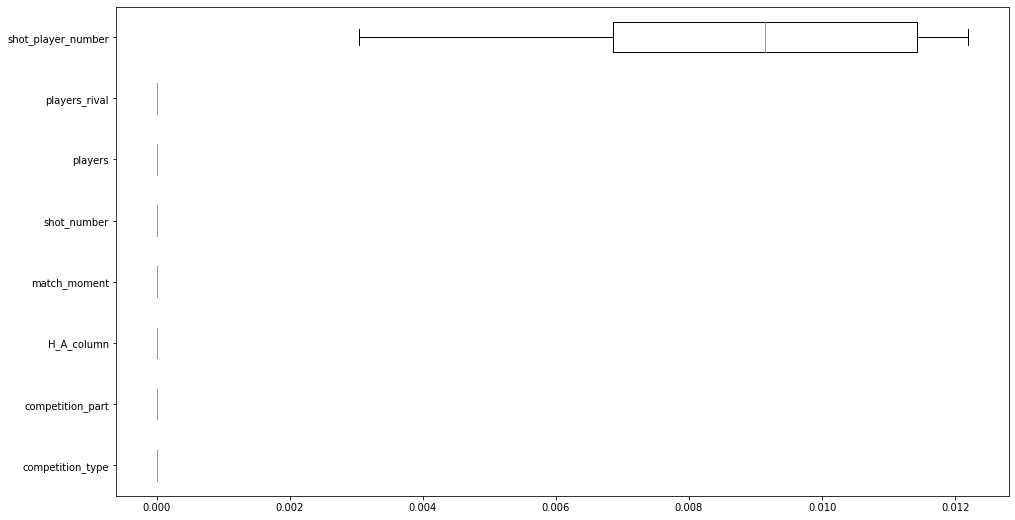

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_p.importances[sorted_idx].T, vert=False, labels=X_penalty_train.columns[sorted_idx])

In [16]:
# Calculate calibration curve on test data
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(y_test, y_pred_xgb_calibrated[:, 1], n_bins=10)

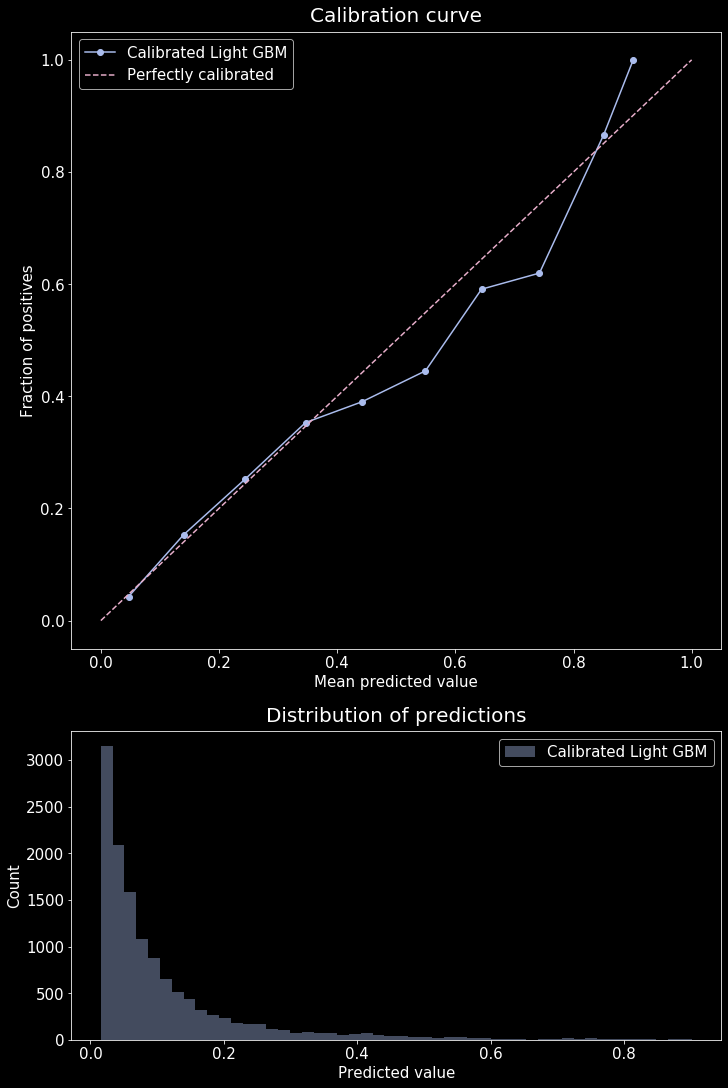

In [17]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_xgb, fraction_of_positives_xgb, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_xgb_calibrated[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);

In [18]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_test, y_pred_xgb_calibrated)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_test, y_pred_xgb_calibrated[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_test, y_pred_xgb_calibrated[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_test, y_pred_xgb_calibrated[:,1], pos_label=y_test.max()))

The log loss of the model with Random Search is: 0.2815737430007132
The ROC AUC score of the model with Random Search is: 0.7914913326810094
Pseudo R-squared, logistic regression: 0.16767812140127913
Brier score, logistic regression: 0.08158076317689497


In [19]:
# Calculate calibration curve on test data
fraction_of_positives_xgb_p, mean_predicted_value_xgb_p = calibration_curve(y_penalty_test, y_pred_xgb_calibrated_p[:, 1],
                                                                            n_bins=10)

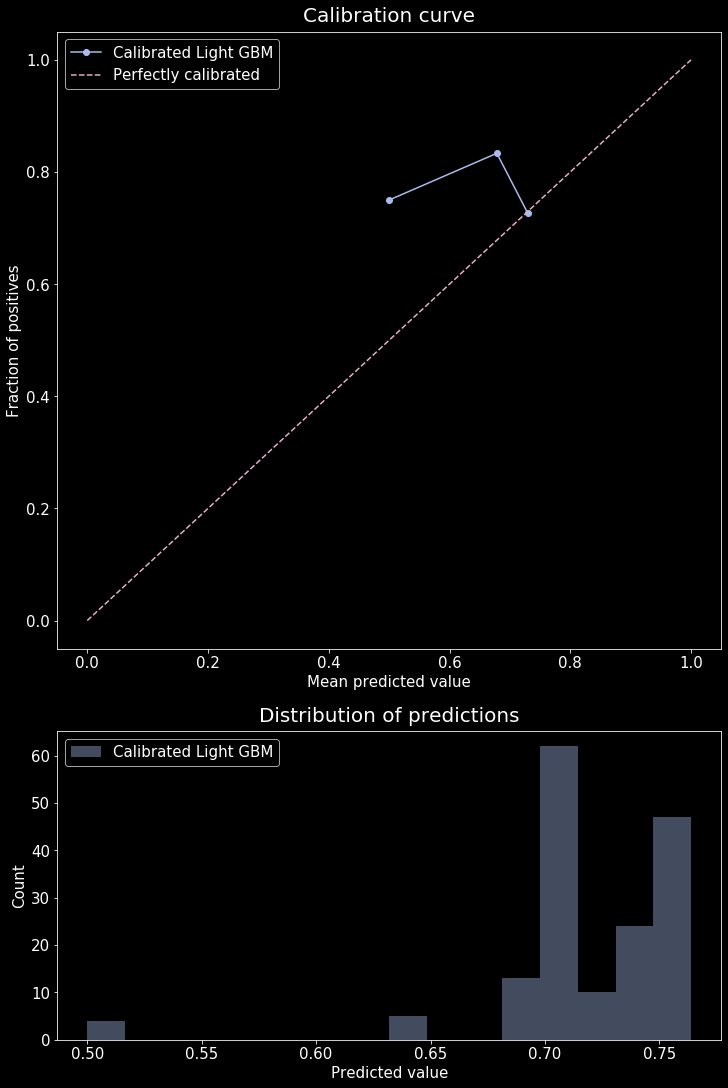

In [20]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_xgb_p, fraction_of_positives_xgb_p, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_xgb_calibrated_p[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);

In [21]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_penalty_test, y_pred_xgb_calibrated_p)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_penalty_test, 
                                                                                  y_pred_xgb_calibrated_p[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_penalty_test, y_pred_xgb_calibrated_p[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_penalty_test, y_pred_xgb_calibrated_p[:,1], 
                                                           pos_label=y_penalty_test.max()))

The log loss of the model with Random Search is: 0.5843684124224113
The ROC AUC score of the model with Random Search is: 0.44986656500190625
Pseudo R-squared, logistic regression: -0.01861376560656436
Brier score, logistic regression: 0.19734683083050605


# Save models

In [22]:
dump(xgb_np, os.path.join(cwd, 'models', 'xgb_model.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\xgb_model.joblib']

In [23]:
dump(xgb_p, os.path.join(cwd, 'models', 'xgb_model_penalty.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\xgb_model_penalty.joblib']

# Save data

In [24]:
# reload shot dataset for ids
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_non_penalty = df[~mask_penalty].copy()
df_penalty = df_penalty[['match_id', 'wyscout_id', 'statsbomb_id']].copy()
df_non_penalty = df_non_penalty[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [25]:
X_train['goal'] = y_train
X_train['split'] = 'train'
X_test['goal'] = y_test
X_test['split'] = 'test'
df_lgbm = pd.concat([X_train, X_test])
# exlcude fake shots
df_lgbm = df_lgbm[df_lgbm.index.isin(df_non_penalty.index)].copy()
df_lgbm = df_lgbm.merge(df_non_penalty, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm.parquet'))



X_penalty_train['goal'] = y_penalty_train
X_penalty_train['split'] = 'train'
X_penalty_test['goal'] = y_penalty_test
X_penalty_test['split'] = 'test'
df_lgbm_penalty = pd.concat([X_penalty_train, X_penalty_test])
# exlcude fake shots
df_lgbm_penalty = df_lgbm_penalty[df_lgbm_penalty.index.isin(df_penalty.index)].copy()
df_lgbm_penalty = df_lgbm_penalty.merge(df_penalty, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm_penalty.parquet'))